In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,20)

In [2]:
!ls

expanded.plaintext.base32.csv.gz
expanded.pyencrypted_v1.b32.csv.gz
expanded.pyencrypted_v1.csv.gz
expanded.pyencrypted_v2.base32.csv.gz
expanded.pyencrypted_v2.csv.gz
iteration_2_compare_base32_alternate_encryption_scheme.ipynb
plaintext.base32.combined.csv.gz
plaintext.combined.csv.gz
plaintext.expanded.csv.gz


In [3]:
master_plain_df = pd.read_csv("expanded.plaintext.base32.csv.gz")
master_encrypt_df = pd.read_csv("expanded.pyencrypted_v2.base32.csv.gz")
master_encrypt_df_nonb32 = pd.read_csv("expanded.pyencrypted_v2.csv.gz")
original_plain_df = pd.read_csv("plaintext.expanded.csv.gz")
encrypted_v1 = pd.read_csv("expanded.pyencrypted_v1.csv.gz")

In [4]:
baseline_columns = [c for c in master_encrypt_df.columns if c.startswith('baseline') and "head" not in c and "tail" not in c]
baseline_columns = [c for c in baseline_columns if "filesize" not in c]

In [5]:
master_plain_df = master_plain_df.sample(frac=1).reset_index(drop=True)
master_encrypt_df = master_encrypt_df.sample(frac=1).reset_index(drop=True)
original_plain_df = original_plain_df.sample(frac=1).reset_index(drop=True)
master_encrypt_df_nonb32 = master_encrypt_df_nonb32.sample(frac=1).reset_index(drop=True)
encrypted_v1 = encrypted_v1.sample(frac=1).reset_index(drop=True)

In [6]:
master_plain_df["is_encrypted"] = 0
master_encrypt_df["is_encrypted"] = 1
original_plain_df["is_encrypted"] = 0
master_encrypt_df_nonb32["is_encrypted"] = 1
encrypted_v1["is_encrypted"] = 1

In [7]:
combined_df = pd.concat([master_plain_df, master_encrypt_df, original_plain_df, master_encrypt_df_nonb32])

In [8]:
combined_df

,Unnamed: 0,Unnamed: 0.1,extended.extension,extended.base_filename,baseline.head_shannon_entropy,baseline.tail_shannon_entropy,baseline.shannon_entropy,baseline.montecarlo_pi,baseline.chisquare_full,baseline.chisquare_begin,...,fourier.value.4byte.242,fourier.value.4byte.243,fourier.value.4byte.244,fourier.value.4byte.245,fourier.value.4byte.246,fourier.value.4byte.247,fourier.value.4byte.248,fourier.value.4byte.249,fourier.value.4byte.250,is_encrypted
0,614,614,.webp,base32.912589.jpg.q100.webp,4.503463,4.959773,5.035088,0.888332,3.065168e+06,268.841723,...,5.612349e+16,6.767379e+16,4.130791e+16,4.731220e+16,7.227851e+16,4.596058e+16,4.066359e+16,6.656743e+16,5.827400e+16,0
1,567,567,.html,base32.087604.html,4.866512,4.899328,4.944777,0.778312,2.794481e+04,245.246033,...,5.436418e+16,5.958774e+16,4.155235e+16,4.364065e+16,7.396072e+16,6.034727e+16,2.959940e+16,1.722817e+17,1.456355e+17,0
2,934,934,.txt,base32.175122.txt,4.534904,4.918340,4.916136,0.703017,9.080338e+03,197.371563,...,2.640765e+16,3.117692e+16,2.114234e+16,3.718221e+16,7.537729e+16,3.920968e+16,3.248925e+16,2.233954e+17,1.617660e+17,0
3,1448,1448,.ppt,base32.202154.ppt,2.066587,0.530660,3.202595,2.225608,2.050938e+05,138.548888,...,2.320652e+16,2.928210e+16,1.563202e+16,2.557972e+16,6.242093e+16,2.968601e+16,2.024394e+16,5.043485e+16,3.781803e+16,0
4,318,318,.webp,base32.161062.jpg.q75.webp,4.793237,4.966273,5.036196,0.904518,4.476906e+04,278.514589,...,4.794680e+16,7.022203e+16,3.909891e+16,4.075623e+16,6.451030e+16,6.166883e+16,3.677944e+16,7.360762e+16,6.607764e+16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80848,539,539,.html,565108.html,5.982354,4.786555,7.208530,3.564000,1.204978e+06,1477.118725,...,8.565307e+17,9.531752e+17,1.099089e+18,1.116083e+18,9.696838e+17,1.135430e+18,1.192002e+18,1.086156e+18,8.686941e+17,1
80849,749,749,.txt,488000.txt,4.431708,3.934020,6.026358,3.564975,1.399119e+06,1080.486340,...,6.902597e+17,6.099852e+17,7.447336e+17,7.832244e+17,8.025134e+17,9.668267e+17,7.591685e+17,6.600057e+17,9.235062e+17,1
80850,31,31,.csv,466319.csv,5.837846,5.299941,7.140976,3.585938,3.637552e+05,1567.613426,...,1.032520e+18,1.210655e+18,1.119858e+18,8.751733e+17,7.331803e+17,8.730464e+17,9.833799e+17,1.045234e+18,7.941866e+17,1
80851,1288,1288,.gif,729587.gif,6.592640,6.783257,7.959307,3.063802,2.607532e+05,7499.672104,...,1.359634e+18,1.567404e+18,1.336789e+18,1.204626e+18,1.419331e+18,1.846516e+18,1.846716e+18,9.416238e+17,9.093771e+17,1


In [9]:
combined_df = combined_df.fillna(0.0)

[0.78926847 0.78806228] [0.78804919 0.78928151] [0.78865836 0.78867143] [16183 16159]
F1 = 0.7886714281297345




<BarContainer object of 6 artists>

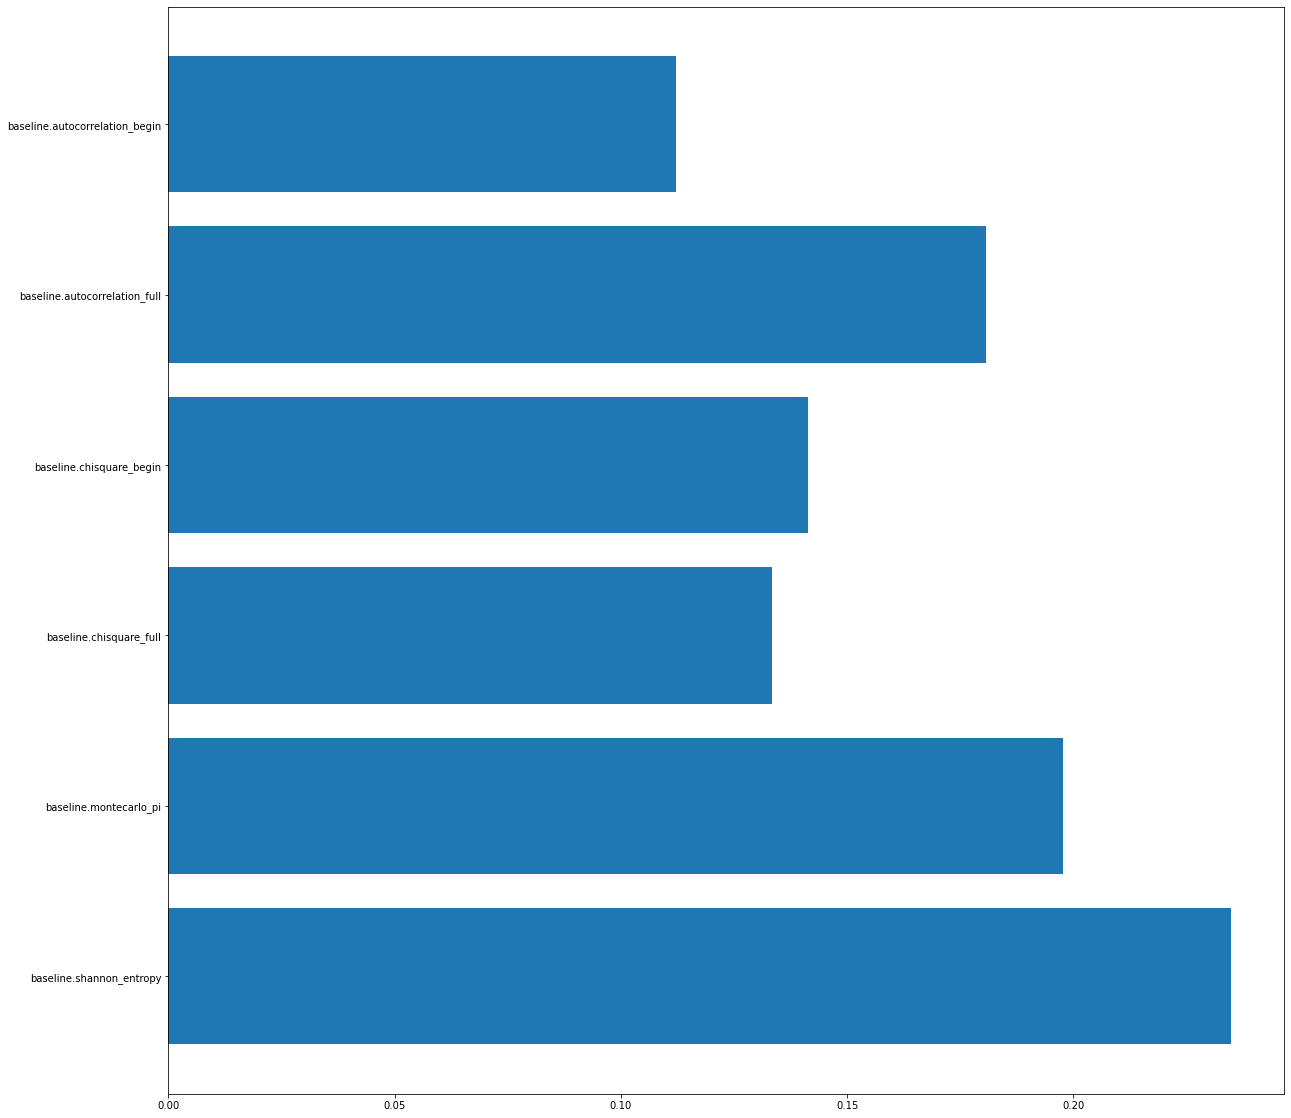

In [10]:
# use basline_columns instead of basic_columns to show what we get from end entropy
basic_columns = [c for c in baseline_columns if "end" not in c]
X, y = combined_df[basic_columns], combined_df["is_encrypted"]
bX_train, bX_test, by_train, by_test = train_test_split(X, y, test_size=0.10, random_state=42)


rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression())]
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(bX_train, by_train)
by_pred = pipeline.predict(bX_test)
precision, recall, fscore, support = precision_recall_fscore_support(by_test, by_pred)
print(precision, recall, fscore, support)
print(f"F1 = {f1_score(by_test, by_pred)}")
print()
print()
plt.barh(X.columns, rfc.feature_importances_)

In [11]:
extra_columns = [c for c in combined_df.columns if "fourier" in c and "value" not in c]
extra_columns = [c for c in extra_columns if "1byte" in c]
advanced_columns = [c for c in combined_df.columns if "advanced" in c]
advanced_columns = [c for c in advanced_columns if "begin" not in c and "end" not in c]
advanced_columns = [c for c in advanced_columns if "head" not in c and "tail" not in c]
advanced_columns = [c for c in advanced_columns if "start" not in c]

/var/folders/z1/hfz3q2b52bx3hb8nh0z1q89c0000gp/T/ipykernel_42412/2894421426.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["fourier.stat.product"] = X["fourier.stat.1byte.mean"].abs() * X["fourier.stat.1byte.autocorr"].abs()


[0.85512911 0.83047505] [0.82469258 0.86007798] [0.83963511 0.84501733] [16183 16159]
F1 = 0.8450173283881559




<BarContainer object of 25 artists>

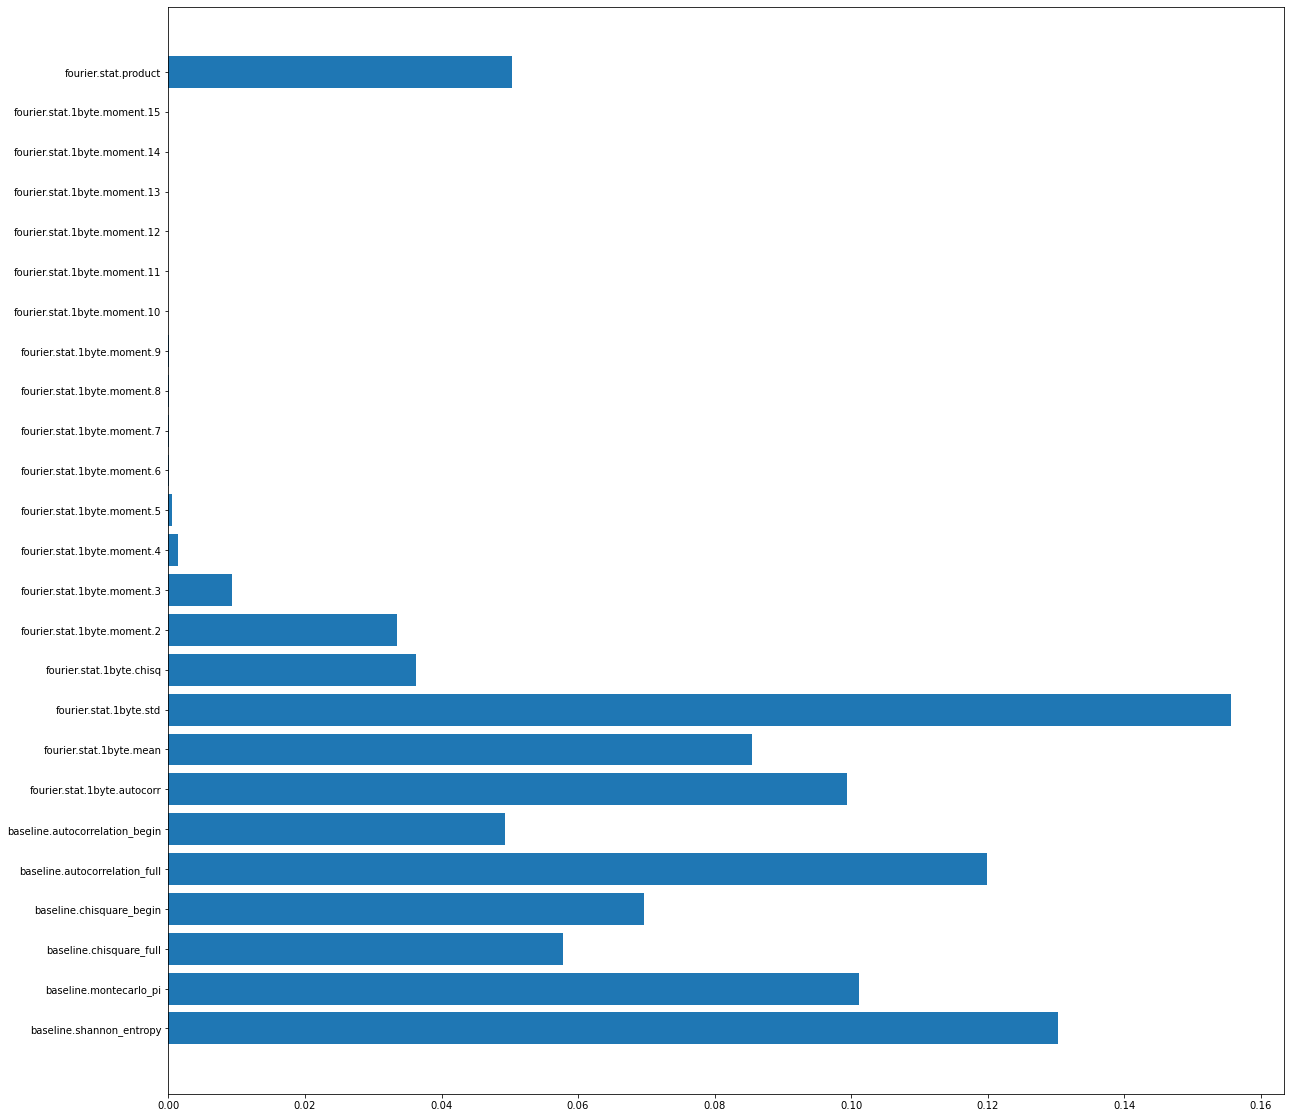

In [12]:
# use basline_columns instead of basic_columns to show what we get from end entropy
basic_columns = [c for c in baseline_columns if "end" not in c]
X, y = combined_df[basic_columns + extra_columns], combined_df["is_encrypted"]
X["fourier.stat.product"] = X["fourier.stat.1byte.mean"].abs() * X["fourier.stat.1byte.autocorr"].abs()
bX_train, bX_test, by_train, by_test = train_test_split(X, y, test_size=0.10, random_state=42)


rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression())]
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(bX_train, by_train)
by_pred = pipeline.predict(bX_test)
precision, recall, fscore, support = precision_recall_fscore_support(by_test, by_pred)
print(precision, recall, fscore, support)
print(f"F1 = {f1_score(by_test, by_pred)}")
print()
print()
plt.barh(X.columns, rfc.feature_importances_)

/var/folders/z1/hfz3q2b52bx3hb8nh0z1q89c0000gp/T/ipykernel_42412/454340755.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["fourier.stat.product"] = X["fourier.stat.1byte.mean"].abs() * X["fourier.stat.1byte.autocorr"].abs()


[0.87181364 0.88164827] [0.88339616 0.86991769] [0.87756668 0.8757437 ] [16183 16159]
F1 = 0.8757436999657352


<BarContainer object of 66 artists>

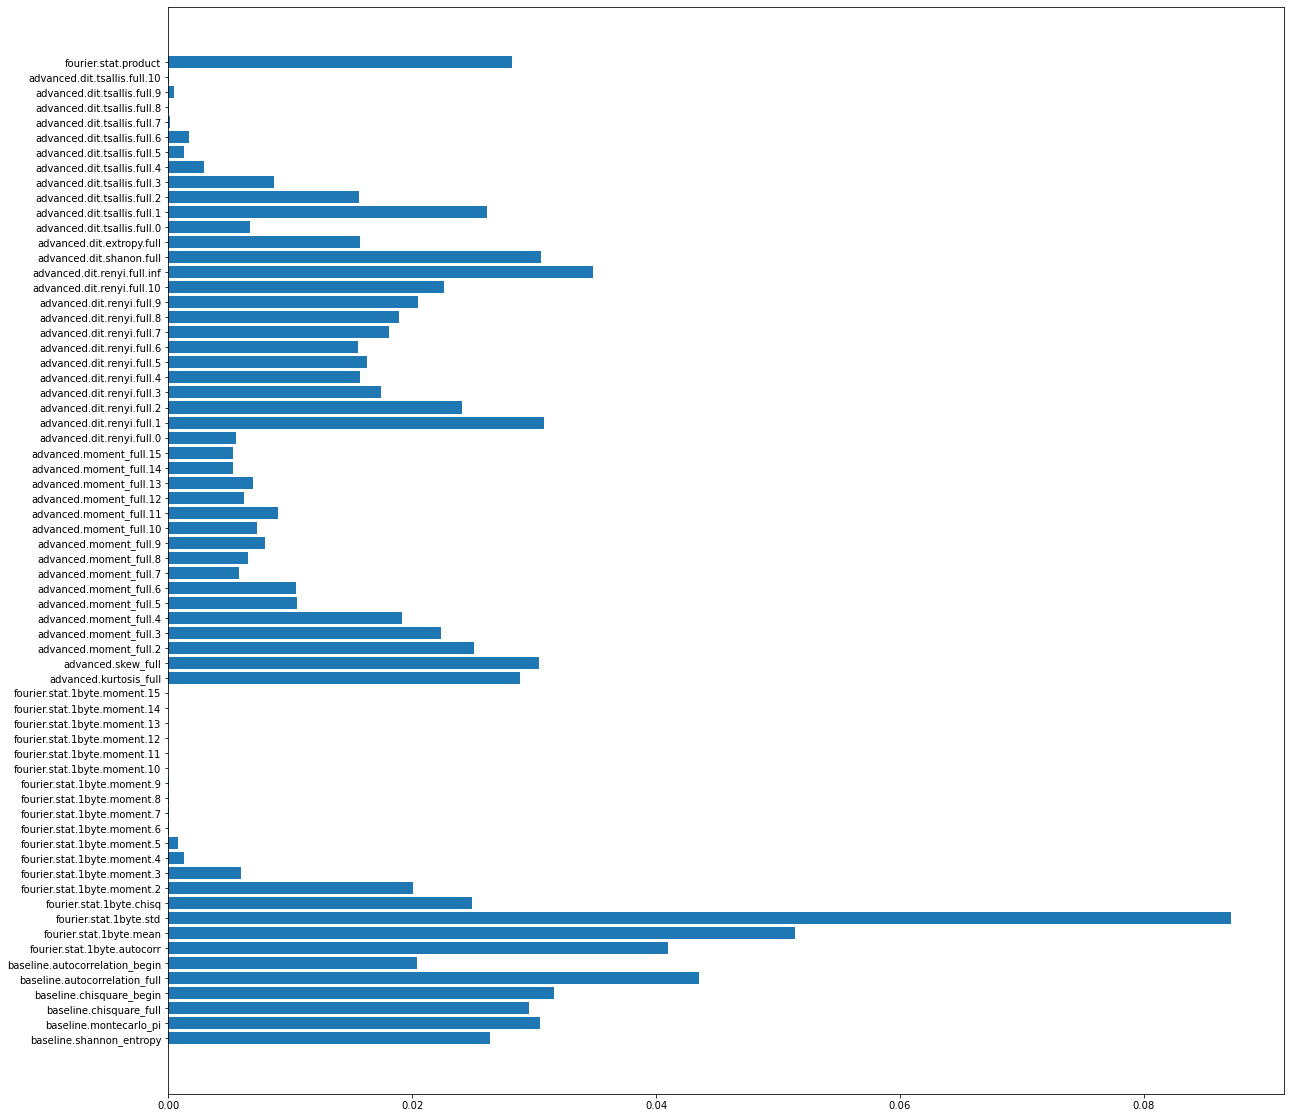

In [13]:
# use basline_columns instead of basic_columns to show what we get from end entropy
basic_columns = [c for c in baseline_columns if "end" not in c]
X, y = combined_df[basic_columns + extra_columns + advanced_columns], combined_df["is_encrypted"]
X["fourier.stat.product"] = X["fourier.stat.1byte.mean"].abs() * X["fourier.stat.1byte.autocorr"].abs()
bX_train, bX_test, by_train, by_test = train_test_split(X, y, test_size=0.10, random_state=42)

rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression())]
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(bX_train, by_train)
by_pred = pipeline.predict(bX_test)
precision, recall, fscore, support = precision_recall_fscore_support(by_test, by_pred)
print(precision, recall, fscore, support)
print(f"F1 = {f1_score(by_test, by_pred)}")

plt.barh(X.columns, rfc.feature_importances_)